# Video Game AB Testing
**by Marty VanHoof**

## Contents
* [Introduction](#intro)

* [The dataset](#dataset)
* [Comparison of 1-day retention rates](#compare_rates) 
* [Is the difference statistically significant?](#one_day_significant)
* [Comparison of 7-day retention rates](#compare_7rates)
* [Conclusion](#conc)


<a id="intro"></a>
## Introduction

This report details the analysis of the results of an AB test run on the game [Cookie Cats](https://www.facebook.com/cookiecatsgame/).  In the game, a player must connect tiles of the same colour to clear the board and win the level.  At various points in the game,  the player will occasionally encounter gates that make them wait for a span of time or make an in-app purchase to progress.  These gates help to drive in-app purchases.  They also force the player to take a break, which would hopefully prolong their enjoyment of the game.

So an important question is:  where should the gate be placed in order to maximize player enjoyment and/or player retention? Initially, the first gate was placed at level 30, but then management decided to run an experiment to see if moving the first gate from level 30 to level 40 had an impact on player retention.  What follows is a detailed analysis of the data gathered from that experiment.   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import display
#import seaborn

%matplotlib inline

<a id="dataset"></a>
## The dataset

The data is from 90,189 players who installed the game while the while the AB-test was in progress.  The variables are:

* `userid` - a unique number that identifies each player.
* `version` - whether the player was put in the control group (gate_30) or the treatment group (gate_40).
* `sum_gamerounds` - the number of game rounds played by the player during the first 14 days after install.
* `retention_1` - did the player come back and play **1 day** after installing?
* `retention_7` - did the player come back and play **7 days** after installing?


Players were randomly assigned to either gate_30 or gate_40.

In [2]:
df = pd.read_csv('cookie_cats_data.csv')

display(df.head())
control = df.query('version == "gate_30"')
treatment = df.query('version == "gate_40"')
print('Number of players in control group (gate_30):', control.shape[0])
print('Number of players in treatment group (gate_40):', treatment.shape[0])

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Number of players in control group (gate_30): 44700
Number of players in treatment group (gate_40): 45489


### Distribution of gamerounds played

The plot below shows the distribution of `sum_gamerounds` for the players that played from 0 to 150 gamerounds.

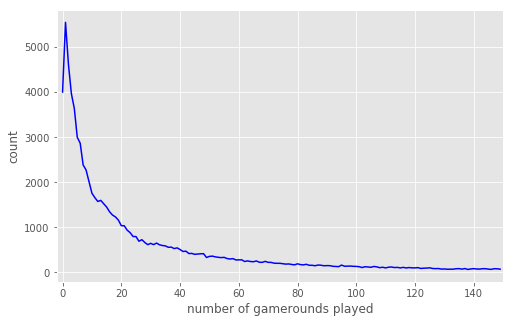

In [3]:
count_by_gamerounds = df.groupby('sum_gamerounds')['userid'].count()

fig, ax = plt.subplots(figsize=(8,5))
count_by_gamerounds.head(150).plot(color='blue')
ax.set_xlabel('number of gamerounds played')
ax.set_ylabel('count')
ax.set_xlim(-2, 150);

<a id="compare_rates"></a>
## Comparison of 1-day retention rates

A common metric in the video game industry for game engagement is **1-day retention rate**.  This is the proportion of players who come back and play the game one day after they have installed it.  Clearly, a video game company would like to increase this retention rate as much as possible so that they can build a larger player base for their games.  The goal of this experiment is to see if moving the first gate from level 30 to level 40 has an impact on player retention, so we are really interested in comparing the retention rates between the treatment and control group.   

### The overall 1-day retention rate

In [4]:
overall_rate = df.retention_1.mean()
print('overall 1-day retention rate:', round(overall_rate, 4))

overall 1-day retention rate: 0.4452


### 1-day retention rates for the control group and treatment group

In [5]:
# control group corresponds to gate_30, treatment groups corresponds to gate_40
control_rate = control.retention_1.mean()
treatment_rate = treatment.retention_1.mean()
print('control 1-day retention rate:', round(control_rate, 4))
print('treatment 1-day retention rate:', round(treatment_rate, 4))
print('observed difference:', round(control_rate - treatment_rate, 4))

control 1-day retention rate: 0.4482
treatment 1-day retention rate: 0.4423
observed difference: 0.0059


<a id="one_day_significant"></a>
## Is the difference statistically significant?

We can see from the calculations above that there was a slight decrease of about 0.59 percentage points when the gate was moved to level 40 versus the control group at level 30.  This may not seem like a lot, but even small changes in retention can have a large impact on the company's revenue.

So is this result a random fluke, or is it unlikely to occur by chance? To answer this question, we should do a hypothesis test.  Let $p_{30}$ be the true 1-day retention rate for the control group and $p_{40}$ the true retention rate for the treatment group.  We want to test the hypotheses

\begin{align*}
H_0 : p_{30} - p_{40} &= 0 \\
H_A : p_{30} - p_{40} &> 0
\end{align*}

To do this test, we will use [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics).  Bootstrapping is a statistical technique that allows us to estimate the sampling distribution of a statistic.  In our case, we want to estimate the sampling distributions of the sample proportions $\widehat{p}_{30}$ and $\widehat{p}_{40}$.  This will allow us to estimate the amount of variation in 1-day retention rates for both the treatment and control group.

### The distributions for $\widehat{p}_{30}$ and $\widehat{p}_{40}$

In the code below, we get 10000 bootstrapped samples and then show density plots that approximate each distribution.  In the plots below, there is some evidence of a small difference in the distributions, although we actually need to test this. 

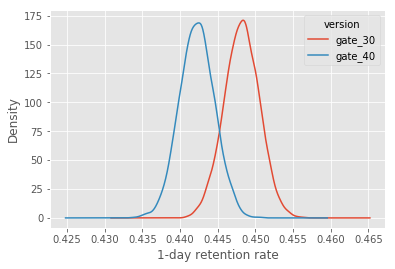

In [12]:
def bootstrap(num_repetitions, column):
    bootsample = []
    for _ in range(num_repetitions):
        boot_mean = df.sample(frac=1, replace=True).groupby('version')[column].mean()
        bootsample.append(boot_mean)
        
    return pd.DataFrame(bootsample) 

bootsample_df = bootstrap(10000, 'retention_1')
bootsample_df.plot.kde()
plt.xlabel('1-day retention rate');

### The distribution of the differences $\widehat{p}_{30} - \widehat{p}_{40}$

Now we're going to essentially subtract the two plots above and get one density plot that represents the distribution of all the differences in 1-day retention rates for the control group and 1-day retention rates for the treatment group.

If there is no significant difference in retention rates (ie. the null hypothesis is true), then the plot below should be centered approximately at zero.


standard deviation = 0.00325


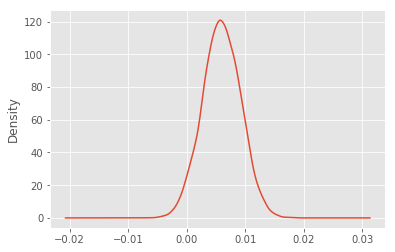

In [13]:
bootsample_df['diff'] = bootsample_df.gate_30 - bootsample_df.gate_40
diff_std = bootsample_df['diff'].std()

# plot a density estimation for the diff column
print('\nstandard deviation =', round(diff_std, 5))
bootsample_df['diff'].plot.kde();

### What can we conclude about the 1-day retention rates?

If the null hypothesis is true, then the sampling distribution should have a mean of 0 and a standard deviation of approximately 0.0033; the same standard deviation as the distribution we plotted directly above.  Recall that the observed difference in proportions of 1-day retention rates is approximately 0.0059.  

What is the probability of getting a value of 0.0059 or something more extreme if there is no difference between the 1-day retention rates for the control group versus the treatment group? This probability is the [p-value](https://en.wikipedia.org/wiki/P-value), and the smaller the p-value, the stronger the evidence we have against the null hypothesis.  If the p-value is smaller than some threshold (called the significance level), then we can reject $H_0$ and conclude that there is enough evidence to support the claim that there is an actual difference in 1-day retention rates between the gate_30 group and the gate_40 group.

Below is a plot of the null distribution along with a vertical line representing where the observed difference lies on the distribution.

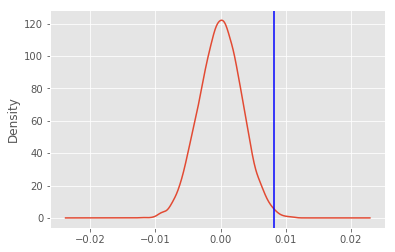

In [19]:
null_dist = np.random.normal(0, diff_std, 10000)
bootsample_df['null_dist'] = null_dist
bootsample_df['null_dist'].plot.kde()
plt.axvline(x=control_rate - treatment_rate, color='blue');

Since the alternative hypothesis is $H_A : p_{30} - p_{40} > 0$, the hypothesis test is right-tailed.  This means that we should find the p-value by looking at the proportion of values in the null distribution that are greater than the observed difference

$$
\textrm{p-value} = \mathrm{Prob}\,(\textrm{difference} > 0.0059 \,\,|\,\, H_0 \textrm{ is true})
$$

and this is the same as the area to the right of the vertical blue line in the null distribution above.  The computation below shows that p-value < 0.01.  If we use a significance level $\alpha = 0.01$, then we can reject $H_0$, so the data provide sufficient evidence to conclude that the 1-day retention rate for gate_30 is larger than the 1-day retention rate for gate_40.

It looks like it's better to keep the first gate at level 30.

In [21]:
observed_diff = control_rate - treatment_rate
p_value = (null_dist > observed_diff).mean()
print('p-value:', p_value)

p-value: 0.0052


<a id="compare_7rates"></a>
## Comparison of 7-day retention rates

The analysis above shows that switching the first gate from gate_30 to gate_40 results in a decrease in the 1-day retention rate.  What about the 7-day retention rate?  The 7-day retention rate is the proportion of players who come back and play the game 7 days after installing it.

Maybe after only one day, many players hadn't reached level 30 or level 40 yet.  In this case, a lot of people wouldn't have been affected by the experiment.  So let's now do the same analysis we did above, but for 7-day retention rates.  That is, we'll do another hypothesis test to see if there is a statistically significant difference between 7-day retention rate for the gate_30 group versus the gate_40 group.

### The observed 7-day retention rates

Again we find that the 7-day retention rate decreases when the first gate is switched from level 30 to level 40.  The observed difference is about 0.82 percentage points.

In [22]:
control_rate = control.retention_7.mean()
treatment_rate = treatment.retention_7.mean()
print('control 7-day retention rate:', round(control_rate, 4))
print('treatment 7-day retention rate:', round(treatment_rate, 4))
print('observed difference:', round(control_rate - treatment_rate, 4))

control 7-day retention rate: 0.1902
treatment 7-day retention rate: 0.182
observed difference: 0.0082


### Bootstrapping again

We want to test whether this decrease in the 7-day retention rate is statistically significant, so we will use bootstrap analysis again.  We will simulate the sampling distribution of the differences in 7-day retention rates between the gate_30 group and gate_40 group and then plot the observed difference and calculate the p-value.  

This time we are testing the null hypothesis that there is no difference in the 7-day retention rates.  Again we have p-value < 0.01, so the data provide sufficient evidence to conclude that the 7-day retention rate is higher when the gate is kept at level 30.


p-value: 0.0012


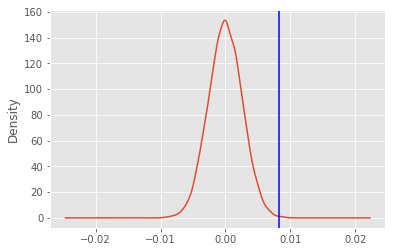

In [23]:
# get 10000 bootstrapped samples
bootsample_df = bootstrap(10000, 'retention_7')

# simulate the distribution of differences under the assumption of no difference in 7-day retention rates
bootsample_df['diff'] = bootsample_df.gate_30 - bootsample_df.gate_40
diff_std = bootsample_df['diff'].std()
null_dist = np.random.normal(0, diff_std, 10000)
bootsample_df['null_dist'] = null_dist

# plot the expected distribution under the assumption of no difference and also plot the observed difference.
# The p-value is the area under the distribution to the right of the blue line
observed_diff = control_rate - treatment_rate
p_value = (null_dist > observed_diff).mean()
print('\np-value:', p_value)
bootsample_df['null_dist'].plot.kde()
plt.axvline(x=observed_diff, color='blue');

<a id="conc"></a>
## Conclusion

The data show that both 1-day and 7-day retention rates are higher when the first gate is kept at level 30 versus being moved to level 40.  Therefore, any competent analyst working for this video game company should recommend that the gate **not** be moved from level 30 to 40.